# Mobile price classification with multilayer perceptron
## Tensorflow
Erik Matovič and Jakub Horvat

[Dataset](https://www.kaggle.com/datasets/iabhishekofficial/mobile-price-classification?select=train.csv)

Predict a price range indicating how high the price is

### 0. Imports

In [97]:
from utils import split_train_val
import tensorflow as tf
from tensorflow import keras
import pandas as pd
#import wandb
from sklearn.model_selection import train_test_split
from utils import check_null_values, print_sum_null, rescale, split_data

In [98]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.reduce_sum(tf.random.normal([1000, 1000])))
print(tf.config.list_physical_devices('GPU'))


2.11.0
Num GPUs Available:  0
tf.Tensor(481.3957, shape=(), dtype=float32)
[]


### 1. Data Preprocessing

Based on [exploratory data analysis](EDA.ipynb) test set does not have target variable price_range. We split our dataset into train-dev-test. We have train and test sets, but we split test set by half to dev-test sets. We will rougly have train-dev-test 67%-16.5%-16.5%. 

In [99]:
# read datasets
df_train = pd.read_csv('../data/train.csv', sep=',')
df_train


,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,794,1,0.5,1,0,1,2,0.8,106,6,...,1222,1890,668,13,4,19,1,1,0,0
1996,1965,1,2.6,1,0,0,39,0.2,187,4,...,915,1965,2032,11,10,16,1,1,1,2
1997,1911,0,0.9,1,1,1,36,0.7,108,8,...,868,1632,3057,9,1,5,1,1,0,3
1998,1512,0,0.9,0,4,1,46,0.1,145,5,...,336,670,869,18,10,19,1,1,1,0


In [100]:
df_test = pd.read_csv('../data/test.csv', sep=',', index_col=0)
df_test


,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
id,,,,,,,,,,,,,,,,,,,,
1,1043,1,1.8,1,14,0,5,0.1,193,3,16,226,1412,3476,12,7,2,0,1,0
2,841,1,0.5,1,4,1,61,0.8,191,5,12,746,857,3895,6,0,7,1,0,0
3,1807,1,2.8,0,1,0,27,0.9,186,3,4,1270,1366,2396,17,10,10,0,1,1
4,1546,0,0.5,1,18,1,25,0.5,96,8,20,295,1752,3893,10,0,7,1,1,0
5,1434,0,1.4,0,11,1,49,0.5,108,6,18,749,810,1773,15,8,7,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,1700,1,1.9,0,0,1,54,0.5,170,7,17,644,913,2121,14,8,15,1,1,0
997,609,0,1.8,1,0,0,13,0.9,186,4,2,1152,1632,1933,8,1,19,0,1,1
998,1185,0,1.4,0,1,1,8,0.5,80,1,12,477,825,1223,5,0,14,1,0,0


In [101]:
df_train.values

array([[8.420e+02, 0.000e+00, 2.200e+00, ..., 0.000e+00, 1.000e+00,
        1.000e+00],
       [1.021e+03, 1.000e+00, 5.000e-01, ..., 1.000e+00, 0.000e+00,
        2.000e+00],
       [5.630e+02, 1.000e+00, 5.000e-01, ..., 1.000e+00, 0.000e+00,
        2.000e+00],
       ...,
       [1.911e+03, 0.000e+00, 9.000e-01, ..., 1.000e+00, 0.000e+00,
        3.000e+00],
       [1.512e+03, 0.000e+00, 9.000e-01, ..., 1.000e+00, 1.000e+00,
        0.000e+00],
       [5.100e+02, 1.000e+00, 2.000e+00, ..., 1.000e+00, 1.000e+00,
        3.000e+00]])

In [102]:
x_train = df_train.values[:, :-1]       #vsetko okrem price range
x_train = x_train.astype('float32')     # input data as floats
x_train


array([[8.420e+02, 0.000e+00, 2.200e+00, ..., 0.000e+00, 0.000e+00,
        1.000e+00],
       [1.021e+03, 1.000e+00, 5.000e-01, ..., 1.000e+00, 1.000e+00,
        0.000e+00],
       [5.630e+02, 1.000e+00, 5.000e-01, ..., 1.000e+00, 1.000e+00,
        0.000e+00],
       ...,
       [1.911e+03, 0.000e+00, 9.000e-01, ..., 1.000e+00, 1.000e+00,
        0.000e+00],
       [1.512e+03, 0.000e+00, 9.000e-01, ..., 1.000e+00, 1.000e+00,
        1.000e+00],
       [5.100e+02, 1.000e+00, 2.000e+00, ..., 1.000e+00, 1.000e+00,
        1.000e+00]], dtype=float32)

In [103]:
y_train = df_train.values[:, -1]  # price range
y_train = y_train.astype('int')
print(y_train)

[1 2 2 ... 3 0 3]


In [104]:
x_train,x_val,y_train,y_val = train_test_split(x_train,y_train,test_size=0.2,random_state=52)
print(x_train.shape,x_val.shape,y_train.shape,y_val.shape)
#print(y_train," sad")
class_labels = [0, 1, 2, 3]
y_train = tf.keras.utils.to_categorical(y_train, num_classes=len(class_labels))
y_val = tf.keras.utils.to_categorical(y_val, num_classes=len(class_labels))
#print(y_train)

(1600, 20) (400, 20) (1600,) (400,)


In [133]:
x_test = df_test.values[:, :]       #vsetko okrem price range
x_test = x_test.astype('float32')
x_test
# y_test = df_test.values[:, -1]  # price range
# y_test = y_test.astype('int')
# print(x_test.shape,y_test.shape)

array([[1.043e+03, 1.000e+00, 1.800e+00, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       [8.410e+02, 1.000e+00, 5.000e-01, ..., 1.000e+00, 0.000e+00,
        0.000e+00],
       [1.807e+03, 1.000e+00, 2.800e+00, ..., 0.000e+00, 1.000e+00,
        1.000e+00],
       ...,
       [1.185e+03, 0.000e+00, 1.400e+00, ..., 1.000e+00, 0.000e+00,
        0.000e+00],
       [1.533e+03, 1.000e+00, 5.000e-01, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       [1.270e+03, 1.000e+00, 5.000e-01, ..., 1.000e+00, 0.000e+00,
        1.000e+00]], dtype=float32)

In [106]:
# train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
#
# # Print the dataset
# for data, label in train_ds:
#     print(data, label)

In [107]:
# batch_size = 32
# tf_train, tf_val = split_train_val(train_ds)
#
# print(tf_train.dataset)
# print(tf_val.dataset)


In [108]:
#shape(tf_train)

In [135]:
model = keras.Sequential([
    keras.layers.Dense(256,input_shape=(20,),name='l1'),
    # keras.layers.Dense(256, activation='relu',name='l2'),
    # keras.layers.Dense(256, activation='relu',name='l3'),
    # keras.layers.Dense(256, activation='sigmoid',name='l4'),
    # keras.layers.Dense(256, activation='sigmoid',name='l5'),
    keras.layers.Dense(4,activation='sigmoid',name='l6')
])


In [136]:
lr = 0.03648030109469176
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy','mse','categorical_accuracy'])


In [137]:
tf.debugging.enable_traceback_filtering()
history = model.fit(x_train,y_train,batch_size=128,epochs=100,validation_data=(x_val,y_val))

Epoch 1/100
13/13 [==============================] - 2s 22ms/step - loss: 417.7837 - accuracy: 0.3525 - mse: 0.3274 - categorical_accuracy: 0.3525 - val_loss: 161.9198 - val_accuracy: 0.5200 - val_mse: 0.2646 - val_categorical_accuracy: 0.5200
Epoch 2/100
13/13 [==============================] - 0s 5ms/step - loss: 147.6944 - accuracy: 0.4056 - mse: 0.2626 - categorical_accuracy: 0.4056 - val_loss: 74.8054 - val_accuracy: 0.3750 - val_mse: 0.4209 - val_categorical_accuracy: 0.3750
Epoch 3/100
13/13 [==============================] - 0s 11ms/step - loss: 51.0812 - accuracy: 0.4087 - mse: 0.2980 - categorical_accuracy: 0.4087 - val_loss: 48.3975 - val_accuracy: 0.4050 - val_mse: 0.2728 - val_categorical_accuracy: 0.4050
Epoch 4/100
13/13 [==============================] - 0s 6ms/step - loss: 24.3096 - accuracy: 0.4812 - mse: 0.2773 - categorical_accuracy: 0.4812 - val_loss: 26.7614 - val_accuracy: 0.3625 - val_mse: 0.2549 - val_categorical_accuracy: 0.3625
Epoch 5/100
13/13 [============

In [112]:
# results = model.evaluate(x_test, y_test, verbose = 4)
# print('test loss, test acc:', results)

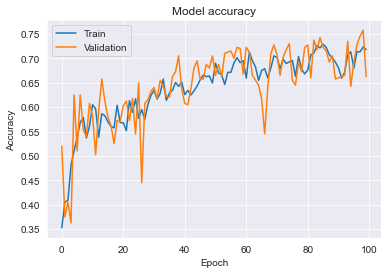

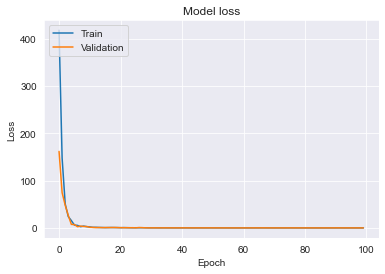

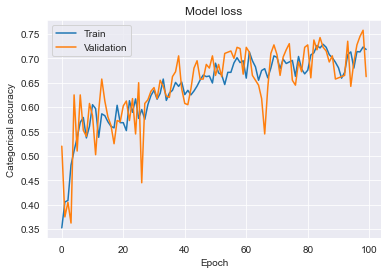

In [139]:
import matplotlib.pyplot as plt

#Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation categorical accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model loss')
plt.ylabel('Categorical accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [140]:
model.predict(x_test)

32/32 [==============================] - 0s 2ms/step


array([[5.0759826e-07, 5.1766582e-02, 3.5560855e-01, 6.1095119e-01],
       [1.7741851e-08, 4.5700099e-02, 5.6521082e-01, 8.5584891e-01],
       [6.8381323e-06, 8.1391931e-02, 2.1344800e-01, 2.0690101e-01],
       ...,
       [1.6272789e-02, 1.8776166e-01, 1.2743962e-01, 2.5872113e-02],
       [9.4694864e-05, 7.8698650e-02, 2.6277274e-01, 8.6531915e-02],
       [6.2599156e-06, 8.3457857e-02, 3.4738734e-01, 3.6395621e-01]],
      dtype=float32)